In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/waterQuality/all4classes.csv')
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,body,Subjectivity,Polarity,Analysis,cod
0,0,0,0,predatory white pointers dingos saltwatercrocs...,0.075066,0.075066,Positive,0
1,1,1,1,this january simply note that are still having...,0.000000,0.000000,Neutral,0
2,2,2,2,pronouns hehim height zodiac sign leo smoke he...,0.000000,0.000000,Neutral,0
3,3,3,3,pronouns hehim height zodiac sign sagittarius ...,-0.075000,-0.075000,Negative,0
4,4,4,4,hoses are inchworm water lilies are powderblue...,-0.166667,-0.166667,Negative,0


In [ ]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['body'].apply(lambda x:len(str(x).split())) 

In [ ]:
print('Info about training data:')
print(train_data['cod'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
2    5572
0    5032
1    4825
3    4395
Name: cod, dtype: int64
Total comments:  19824


In [ ]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :52


In [ ]:

num_words = 20000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['body'].values.astype(str).tolist())

In [ ]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['body'],\
                                                      train_data['cod'],\
                                                      test_size=0.2,\
                                                      random_state=0)

In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-43-9ee80a7500df>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-43-9ee80a7500df>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [ ]:
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

[0, 1, 2, 3]

In [ ]:
# looking for top 30k comments
max_features = 20000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [ ]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 20,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/20
496/496 [==============================] - 9s 17ms/step - loss: 1.1122 - accuracy: 0.5159 - auc: 0.7895 - val_loss: 0.8303 - val_accuracy: 0.7130 - val_auc: 0.9104
Epoch 2/20
496/496 [==============================] - 10s 19ms/step - loss: 0.6845 - accuracy: 0.7907 - auc: 0.9469 - val_loss: 0.7784 - val_accuracy: 0.7733 - val_auc: 0.9326
Epoch 3/20
496/496 [==============================] - 8s 16ms/step - loss: 0.5009 - accuracy: 0.8794 - auc: 0.9774 - val_loss: 0.8706 - val_accuracy: 0.7647 - val_auc: 0.9296
Epoch 4/20
496/496 [==============================] - 8s 15ms/step - loss: 0.3830 - accuracy: 0.9272 - auc: 0.9904 - val_loss: 0.9573 - val_accuracy: 0.7627 - val_auc: 0.9264
Epoch 5/20
496/496 [==============================] - 8s 15ms/step - loss: 0.3164 - accuracy: 0.9571 - auc: 0.9949 - val_loss: 1.0621 - val_accuracy: 0.7617 - val_auc: 0.9210


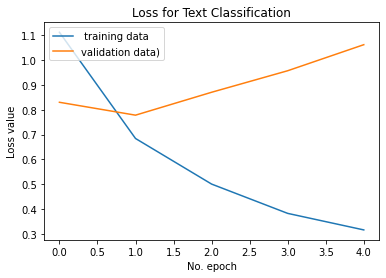

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

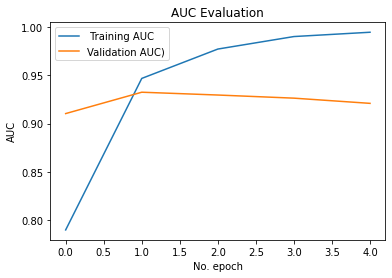

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
X_test

11838    struggling hard the lastyear lol looking for s...
8942     after sum drinkswhether its the same day night...
3494            use bread machine literally add water lmao
3261     those moments are the reason love this sport w...
8434     fun after effects having cvd year later coughi...
                               ...                        
7803     album going called shallow water shall will ha...
19595    proof pic one glass water and one floating nee...
16312    thank you cosmosmagazine thanks research aibn ...
9366     digestive system entirely doesnt work anymore ...
13671    see most are not not sensitive little princess...
Name: body, Length: 3965, dtype: object

In [ ]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-53-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [ ]:
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
124/124 [==============================] - 0s 3ms/step


array([0, 1, 2, ..., 3, 1, 2])

In [ ]:
y_test.shape
y_test

11838    2
8942     1
3494     0
3261     0
8434     1
        ..
7803     1
19595    3
16312    3
9366     1
13671    2
Name: cod, Length: 3965, dtype: int64

In [ ]:
labels = [0, 1, 2, 3]
#labels = labels.values.astype(int).astype(str)
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

           0       0.78      0.66      0.71       972
           1       0.85      0.88      0.87       996
           2       0.73      0.78      0.75      1091
           3       0.69      0.72      0.70       906

    accuracy                           0.76      3965
   macro avg       0.76      0.76      0.76      3965
weighted avg       0.76      0.76      0.76      3965

